# Chap 3 線形回帰 (Bayes)

## 問題設定


$N$ 個の観測値 ${\bf x}_n$, $(n=1, ..., N)$ とそれに対応する目標値 ${\bf t_n}$ のデータから
${\bf x}$ と ${\bf t}$ の関係をモデル化する。

線形回帰では、$M$ 個の重み係数 $w_j$, $(j=1, ..., M)$ と基底関数 ${\phi_j({\bf x})}$ の線形和
$$
y({\bf x}, {\bf w}) = \sum_{j=1}^{M} w_j \phi_j({\bf x}) = {\bf w}^T {\bf \phi(x)}
$$
をモデルとし、 $w_j$ を推定する。


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## 基底関数

1. そのまま
    $$\phi_j(x) = x$$
2. 多項式
    $$\phi_j(x) = x^j$$
3. ガウス
    $$\phi_j(x) = \exp\left(-\frac{(x-\mu_j)^2}{2s^2}\right)$$
4. ロジスティックシグモイド
    $$\phi_j(x) = \frac{1}{1 + \exp\left((x - \mu_j)/s\right)}$$

(図 3.1 (p137))

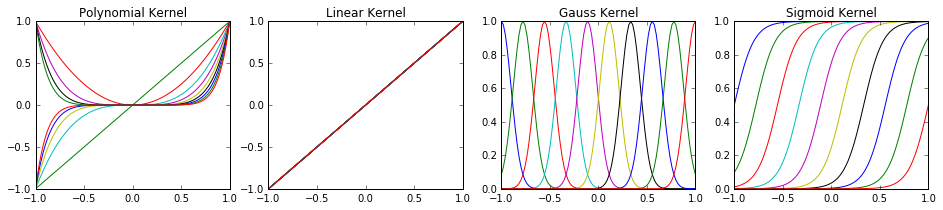

In [2]:
def basisNone(x, dmy1=None, dmy2=None, dmy3=None):
    return x

def basisPoly(x, j, dmy1=None, dmy2=None):
    return x ** j

def basisGauss(x, j, mu, s):
    return np.exp(- (x-mu[j]) ** 2 / (2 * s ** 2))

def basisSigmoid(x, j, mu, s):
    return 1.0 / (1 + np.exp(-(x - mu[j])/s))

basis = {
    "Linear": basisNone,
    "Polynomial": basisPoly,
    "Gauss": basisGauss,
    "Sigmoid": basisSigmoid,
}

x = np.linspace(-1, 1, 100)
mu = np.linspace(-1, 1, 10)

plt.figure(figsize=(16, 3))
for ikey, key in enumerate(basis):
    plt.subplot(1, 4, ikey + 1)
    plt.title(key + " Kernel")
    for j in range(len(mu)):
        plt.plot(x, [basis[key](tmpx, j, mu, 0.1) for tmpx in x])


In [3]:
def y(x, w, basisName, mu=None, s=None):
    ret = w[0]
    for index in range(1, len(w)):
        ret += w[index] * basis[basisName](x, index, mu, s)
    return ret

# 例題:  $\sin$ 関数を使った以下の関係式を、$M$ 次元で回帰

観測は加法性ノイズ $\epsilon$ が含まれる
$$
y(x) = 2  \sin(x) + 3 + \epsilon \\
\epsilon \sim N(0, \beta^{-1})
$$
* $x \in [-5, 5]$
* $M$: 線形回帰の次元数
* $N$: サンプル数
* $\beta$: 加法性ノイズの精度

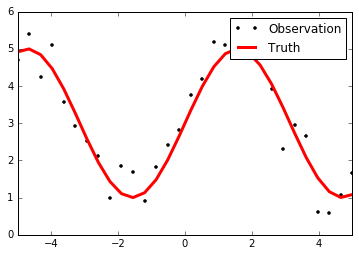

In [291]:
N = 30   # サンプル数
M = 5     # モデル次元
b  = 2.   # ノイズの精度

x_opt = np.linspace(-5, 5, N)
y_opt = 2 * np.sin(x_opt) + 3
y_obs = (y_opt + np.random.normal(0, 1.0/b, len(x_opt)))[:, np.newaxis]

plt.plot(x_opt, y_obs, "k.", label="Observation")
plt.plot(x_opt, y_opt, "r-", linewidth=3, label="Truth")
plt.xlim(-5, 5)
plt.legend()

# ${\bf w}$ のベイズ推定

## ${\bf w}$ の事前分布

観測は加法性ガウスノイズを持つので、共役事前分布はガウス分布
$$
p({\bf w}) = N ({\bf w} | {\bf m_0, S_0})
$$
$w$ に以下の仮定を置く
$$
p({\bf w}) = N ({\bf w} | {0}, \alpha^{-1}{\bf I})
$$

## ${\bf w}$ の事後分布
事後分布
$$
p({\bf w} | {\bf t}) = N({\bf w} | {\bf m}_N, {\bf S}_N)\\
{\bf m}_N = \beta {\bf S}_N{\bf \Phi}^T{\bf t}\\
{\bf S}_N^{-1}=\alpha{\bf I}+ \beta {\bf \Phi}^T{\bf \Phi}
$$

予測分布の分散 (エラーバー)
$$
\sigma^2(x) = \frac{1}{\beta} + \phi({\bf x})^T {\bf S}_N \phi({\bf x})
$$

## $\alpha$, $\beta$ の推定
1. 適当な $\alpha$, $\beta$　を初期値に設定
2. 次の $\gamma$ と、上式で定義される ${\bf m}_N$ を計算
$$
\gamma = \sum_i^{N} \frac{\lambda_i}{\alpha + \lambda_i}
$$
3. $\alpha$, $\beta$ を更新
$$
\alpha = \frac{\gamma}{{\bf m}_N^T{\bf m}_N}
$$
$$
\frac{1}{\beta} = \frac{1}{N-\gamma}\sum_{n=1}^{N}\left(t_n-{\bf m}_N^T \phi({\bf x}\right)^2
$$
4. 2 に戻る


In [292]:
# 計画行列を求める
def makeDesignMatrix(x, basis, mu, s):
    ret = np.zeros((len(x), len(mu)))
    for i in range(len(x)):
        for j in range(len(mu)):
            ret[i][ j] = basis(x[i], j, mu, s)
    return ret, ret.transpose()

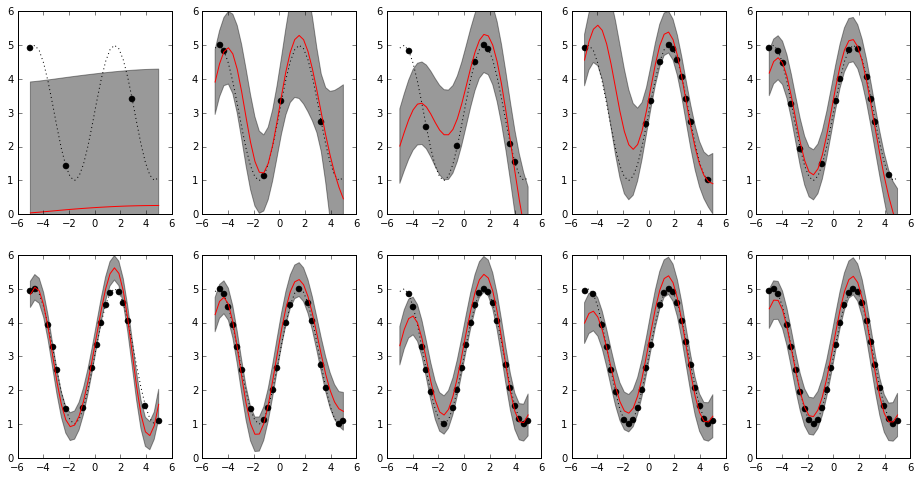

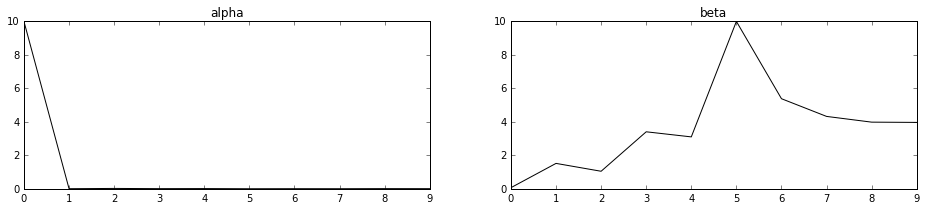

In [307]:

M, key = 15, "Sigmoid"

alphas = []
betas = []

plt.figure(figsize=(16,8))
for index, size in enumerate(np.linspace(3, len(x_opt)-1, 10)):
    # extract data
    size = int(size)
    indices = sorted(np.random.choice(range(len(x_opt)), size, False))    
    x_opt_tmp = x_opt[indices]
    y_opt_tmp = y_opt[indices]
    y_obs_tmp = y_obs[indices]
    
    # generate Phi
    mu = np.linspace(min(x_opt_tmp), max(x_opt_tmp), M)
    s = 1.0
    phi, phit = makeDesignMatrix(x_opt_tmp, basis[key], mu, s)
    phit = phi.transpose()        

    # eigenvalues of Phi
    eigs = np.linalg.eigvalsh(beta * phit.dot(phi))
    
    # estimate values including alpha, beta
    alpha, beta = 0.0001, 0.1
    for i in range(10):
        sN = np.linalg.inv((alpha) * np.eye(M) + beta * phit.dot(phi))
        mN = beta * sN.dot(phit).dot(y_obs_tmp)
        mNt = mN.transpose()
        gamma = sum([eig / (alpha + eig) for eig in eigs])

        beta = 1 / (1/(size - gamma) * sum([(y_obs_tmp[i] - mNt.dot(phi[i, :]))**2 for i in range(size)]))
        alpha = gamma / (mNt.dot(mN))
        beta = np.clip(float(beta), 0, 10)
        alpha = np.clip(float(alpha), 0, 10)
    alphas.append(alpha)
    betas.append(beta)
    
    # Plot estimations and sigmas from estimated values
    # alpha, beta, mN, SN
    phi, phit = makeDesignMatrix(x_opt, basis[key], mu, s)
    y_out = np.array([np.dot(mN.transpose(), phi[i, :]) for i in range(N)])
    sigma = np.sqrt(np.array([1.0 / beta + phi[i, :].transpose().dot(sN).dot(phi[i, :]) for i in range(N)]))

    # Plot estimations
    plt.subplot(2, 5, index+1)
    plt.plot(x_opt, y_opt, "k:")
    plt.plot(x_opt_tmp, y_opt_tmp, "ko")
    plt.plot(x_opt, y_out, "r-")
    plt.fill_between(x_opt, y_out[:, 0] - sigma, y_out[:, 0] + sigma, facecolor="k", alpha=0.4)
    plt.ylim([0, 6])

# Plot aplhas and betas
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.plot(alphas, "k-"); plt.title("alpha")
plt.subplot(1, 2, 2)
plt.plot(betas, "k-"); plt.title("beta")